In [1]:
import scanpy as sc
import pertpy as pt
import numpy as np
import pandas as pd
import pertpy as pt
from tqdm import tqdm
import anndata
import pickle
import re

ModuleNotFoundError: No module named 'pertpy'

In [2]:
print(pt.__version__)

0.7.0


In [3]:
output_dir = "/lustre/groups/ml01/workspace/ot_perturbation/data/norman"

In [4]:
adata = pt.dt.norman_2019()

#### DEG calculation

In [12]:
def rank_genes_groups_by_cov(
    adata,
    groupby,
    control_group,
    covariate,
    n_genes=50,
    rankby_abs=True,
    key_added="rank_genes_groups_cov",
    return_dict=False,
):
    gene_dict = {}
    cov_categories = adata.obs[covariate].unique()
    for cov_cat in cov_categories:
        # name of the control group in the groupby obs column
        control_group_cov = control_group  # "_".join([cov_cat, control_group])
        # subset adata to cells belonging to a covariate category
        adata_cov = adata[adata.obs[covariate] == cov_cat]
        # compute DEGs
        sc.tl.rank_genes_groups(
            adata_cov,
            groupby=groupby,
            reference=control_group_cov,
            rankby_abs=rankby_abs,
            n_genes=n_genes,
            use_raw=False,
        )
        # add entries to dictionary of gene sets
        de_genes = pd.DataFrame(adata_cov.uns["rank_genes_groups"]["names"])
        for group in de_genes:
            gene_dict[group] = de_genes[group].tolist()
    adata.uns[key_added] = gene_dict
    if return_dict:
        return gene_dict


def get_DE_genes(adata):
    adata.obs.loc[:, "control"] = adata.obs.condition.apply(lambda x: 1 if x == "control" else 0)
    adata.obs = adata.obs.astype("category")
    rank_genes_groups_by_cov(
        adata,
        groupby="condition",
        covariate="cell_line",
        control_group="ctrl",
        n_genes=50,
        key_added="rank_genes_groups_cov_all",
    )
    return adata

#### Add the ESM2 embeddings

In [5]:
import glob
import torch

# Specify the folder path
folder_path = '/lustre/groups/ml01/workspace/ot_perturbation/pert_embeddings/norman/norman/'

# Use glob to get all .pt files in the folder
pt_files = glob.glob(folder_path + '*.pt')

In [6]:
genes_pert = {}

for path in pt_files:
    split_path = path.split('_')
    gene = split_path[3]
    genes_pert[gene] = torch.load(path)['mean_representations'][36]

In [7]:
adata.obs[['gene_1', 'gene_2']] = adata.obs['perturbation_name'].str.split('+', expand=True)

In [8]:
adata.obs['gene_2'].fillna('control', inplace=True)

/tmp/ipykernel_244613/4207078196.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adata.obs['gene_2'].fillna('control', inplace=True)


In [9]:
adata.obs

,guide_identity,read_count,UMI_count,coverage,gemgroup,good_coverage,number_of_cells,guide_AHR,guide_ARID1A,guide_ARRDC3,...,total_counts,total_counts_mt,pct_counts_mt,leiden,perturbation_name,perturbation_type,perturbation_value,perturbation_unit,gene_1,gene_2
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGAAGAAGC-1,NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0,1252,67,18.686567,1,True,2,0,0,0,...,19413.0,1327.0,6.835625,10,control,genetic,NaN,NaN,control,control
AAACCTGAGGCATGTG-1,TSC22D1_NegCtrl0__TSC22D1_NegCtrl0,2151,104,20.682692,1,True,1,0,0,0,...,13474.0,962.0,7.139676,3,TSC22D1,genetic,NaN,NaN,TSC22D1,control
AAACCTGAGGCCCTTG-1,KLF1_MAP2K6__KLF1_MAP2K6,1037,59,17.576271,1,True,1,0,0,0,...,23228.0,1548.0,6.664371,7,KLF1+MAP2K6,genetic,NaN,NaN,KLF1,MAP2K6
AAACCTGCACGAAGCA-1,NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0,958,39,24.564103,1,True,1,0,0,0,...,6842.0,523.0,7.643963,2,control,genetic,NaN,NaN,control,control
AAACCTGCAGACGTAG-1,CEBPE_RUNX1T1__CEBPE_RUNX1T1,244,14,17.428571,1,True,1,0,0,0,...,9130.0,893.0,9.780942,10,CEBPE+RUNX1T1,genetic,NaN,NaN,CEBPE,RUNX1T1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCAGTACGT-8,FOXA3_NegCtrl0__FOXA3_NegCtrl0,2068,95,21.768421,8,True,1,0,0,0,...,14727.0,898.0,6.097644,3,FOXA3,genetic,NaN,NaN,FOXA3,control
TTTGTCATCCACTCCA-8,CELF2_NegCtrl0__CELF2_NegCtrl0,829,33,25.121212,8,True,1,0,0,0,...,9750.0,566.0,5.805128,10,CELF2,genetic,NaN,NaN,CELF2,control
TTTGTCATCCCAACGG-8,BCORL1_NegCtrl0__BCORL1_NegCtrl0,136,9,15.111111,8,True,1,0,0,0,...,8670.0,490.0,5.651672,4,BCORL1,genetic,NaN,NaN,BCORL1,control


In [10]:
embedding_dim = genes_pert['ENSG00000125931'].shape[0]


In [11]:
mapping = pd.DataFrame()

In [12]:
mapping.index = adata.var.index

In [13]:
mapping['index'] = adata.var['index']

In [14]:
mapping

,index
gene_symbols,
RP11-34P13.3,ENSG00000243485
RP11-34P13.7,ENSG00000238009
FO538757.2,ENSG00000279457
AP006222.2,ENSG00000228463
RP4-669L17.10,ENSG00000237094
...,...
AL592183.1,ENSG00000273748
AC007325.4,ENSG00000278817
AL354822.1,ENSG00000278384


In [15]:
for path in pt_files:
    if 'KIAA1804' in path:
        print(path)
        break

/lustre/groups/ml01/workspace/ot_perturbation/pert_embeddings/norman/norman/from_ENSG00000143674_entry_Q5TCX8_gene_names_MAP3K21_KIAA1804_MLK4_102.pt


In [16]:
for path in pt_files:
    if 'C19orf26' in path:
        print(path)
        break

/lustre/groups/ml01/workspace/ot_perturbation/pert_embeddings/norman/norman/from_ENSG00000099625_entry_Q8N350_gene_names_CBARP_C19orf26_101.pt


In [17]:
for path in pt_files:
    if 'C3orf72' in path:
        print(path)
        break

/lustre/groups/ml01/workspace/ot_perturbation/pert_embeddings/norman/norman/from_ENSG00000206262_entry_Q6ZUU3_gene_names_FOXL2NB_C3orf72_103.pt


In [18]:
for path in pt_files:
    if 'C19orf26' in path:
        print(path)
        break

/lustre/groups/ml01/workspace/ot_perturbation/pert_embeddings/norman/norman/from_ENSG00000099625_entry_Q8N350_gene_names_CBARP_C19orf26_101.pt


In [19]:
mapping.loc['KIAA1804'] = 'ENSG00000143674'
mapping.loc['C19orf26'] = 'ENSG00000099625'
mapping.loc['C3orf72'] = 'ENSG00000206262'
mapping.loc['KIAA1804'] = 'ENSG00000143674'

In [20]:
import numpy as np
import anndata

# Assuming you have an AnnData object named 'adata'
# and a dictionary named 'embedding_dict' with ENSEMBL IDs as keys and embeddings as values

# Initialize arrays to store embeddings for gene_1 and gene_2
emb_1_list = []
emb_2_list = []

# Iterate through gene_1 and gene_2 columns
for gene_1, gene_2 in zip(adata.obs['gene_1'], adata.obs['gene_2']):
    # Fetch ENSEMBL IDs for gene_1 and gene_2

    ensembl_gene_1 = None
    ensembl_gene_2 = None 
    
    if gene_1 != 'control':
        ensembl_gene_1 = mapping.loc[gene_1]['index']
    if gene_2 != 'control':
        ensembl_gene_2 = mapping.loc[gene_2]['index']
    
    # Fetch embeddings from embedding_dict
    emb_1 = genes_pert.get(ensembl_gene_1, np.zeros(embedding_dim))
    emb_2 = genes_pert.get(ensembl_gene_2, np.zeros(embedding_dim))
    
    # Append embeddings to lists
    emb_1_list.append(emb_1)
    emb_2_list.append(emb_2)

# Convert lists to arrays
emb_1_array = np.array(emb_1_list)
emb_2_array = np.array(emb_2_list)

# Assign arrays to obsm attribute
adata.obsm['emb_1'] = emb_1_array
adata.obsm['emb_2'] = emb_2_array


In [21]:
adata.obsm['emb_2']

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.0421168 , -0.06285824, -0.02540199, ..., -0.01291838,
        -0.1228148 , -0.03189985],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.06235615, -0.05096268,  0.03575513, ...,  0.0492071 ,
        -0.1001324 , -0.0039172 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [22]:
adata.obs.perturbation_name

index
AAACCTGAGAAGAAGC-1          control
AAACCTGAGGCATGTG-1          TSC22D1
AAACCTGAGGCCCTTG-1      KLF1+MAP2K6
AAACCTGCACGAAGCA-1          control
AAACCTGCAGACGTAG-1    CEBPE+RUNX1T1
                          ...      
TTTGTCATCAGTACGT-8            FOXA3
TTTGTCATCCACTCCA-8            CELF2
TTTGTCATCCCAACGG-8           BCORL1
TTTGTCATCCTCCTAG-8    PTPN12+ZBTB10
TTTGTCATCTGGCGAC-8           MAP4K3
Name: perturbation_name, Length: 111255, dtype: category
Categories (237, object): ['AHR', 'AHR+FEV', 'AHR+KLF1', 'ARID1A', ..., 'ZBTB25', 'ZC3HAV1', 'ZNF318', 'control']

In [23]:
adata.obs["perturbation_name"].value_counts()

perturbation_name
control          11835
KLF1              1954
BAK1              1451
CEBPE             1230
CEBPE+RUNX1T1     1215
                 ...  
CBL+UBASH3A         64
CEBPA+CEBPB         64
CEBPB+JUN           59
C3orf72+FOXL2       59
CEBPA+JUN           54
Name: count, Length: 237, dtype: int64

In [24]:
adata.obs["gene_1"].value_counts()

gene_1
control    11835
CEBPE       5313
ETS2        3632
KLF1        3220
DUSP9       3032
           ...  
CITED1       215
PLK4         194
NIT1         191
ZBTB10       160
HES7         126
Name: count, Length: 106, dtype: int64

In [25]:
adata.obs["gene_2"].value_counts()

gene_2
control    69570
UBASH3B     3742
KLF1        2911
TGFBR2      2758
MAPK1       2226
SET         2088
ETS2        2044
PTPN12      1761
MAP2K6      1581
TBX3        1463
PRTG        1381
RUNX1T1     1215
ZC3HAV1     1112
ZBTB25       961
HOXB9        917
MAP2K3       841
IGDCC3       823
LYL1         814
IKZF3        691
PTPN9        669
SAMD1        651
LHX1         645
ZBTB10       636
MAP7D1       601
SNAI1        594
OSR2         593
CNN1         585
FOXL2        571
UBASH3A      552
ZBTB1        548
POU3F2       525
SPI1         481
FOXF1        447
FEV          435
SGK1         356
TBX2         349
SLC38A2      338
TMSB4X       328
CEBPE        293
ISL2         284
ZNF318       245
CDKN1C       232
FOSB         222
FOXA3        216
MEIS1        193
BCL2L11      175
CDKN1B       134
JUN          113
PRDM1        105
KIF2C         95
STIL          81
CEBPB         64
Name: count, dtype: int64

In [26]:
adata.X = adata.layers["counts"]



In [27]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [28]:
sc.pp.highly_variable_genes(adata, inplace=True, n_top_genes=2000)

In [29]:
adata = adata[:,adata.var["highly_variable"]==True]

In [30]:
adata

View of AnnData object with n_obs × n_vars = 111255 × 2000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KI

In [31]:
adata.obs

,guide_identity,read_count,UMI_count,coverage,gemgroup,good_coverage,number_of_cells,guide_AHR,guide_ARID1A,guide_ARRDC3,...,total_counts,total_counts_mt,pct_counts_mt,leiden,perturbation_name,perturbation_type,perturbation_value,perturbation_unit,gene_1,gene_2
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGAAGAAGC-1,NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0,1252,67,18.686567,1,True,2,0,0,0,...,19413.0,1327.0,6.835625,10,control,genetic,NaN,NaN,control,control
AAACCTGAGGCATGTG-1,TSC22D1_NegCtrl0__TSC22D1_NegCtrl0,2151,104,20.682692,1,True,1,0,0,0,...,13474.0,962.0,7.139676,3,TSC22D1,genetic,NaN,NaN,TSC22D1,control
AAACCTGAGGCCCTTG-1,KLF1_MAP2K6__KLF1_MAP2K6,1037,59,17.576271,1,True,1,0,0,0,...,23228.0,1548.0,6.664371,7,KLF1+MAP2K6,genetic,NaN,NaN,KLF1,MAP2K6
AAACCTGCACGAAGCA-1,NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0,958,39,24.564103,1,True,1,0,0,0,...,6842.0,523.0,7.643963,2,control,genetic,NaN,NaN,control,control
AAACCTGCAGACGTAG-1,CEBPE_RUNX1T1__CEBPE_RUNX1T1,244,14,17.428571,1,True,1,0,0,0,...,9130.0,893.0,9.780942,10,CEBPE+RUNX1T1,genetic,NaN,NaN,CEBPE,RUNX1T1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCAGTACGT-8,FOXA3_NegCtrl0__FOXA3_NegCtrl0,2068,95,21.768421,8,True,1,0,0,0,...,14727.0,898.0,6.097644,3,FOXA3,genetic,NaN,NaN,FOXA3,control
TTTGTCATCCACTCCA-8,CELF2_NegCtrl0__CELF2_NegCtrl0,829,33,25.121212,8,True,1,0,0,0,...,9750.0,566.0,5.805128,10,CELF2,genetic,NaN,NaN,CELF2,control
TTTGTCATCCCAACGG-8,BCORL1_NegCtrl0__BCORL1_NegCtrl0,136,9,15.111111,8,True,1,0,0,0,...,8670.0,490.0,5.651672,4,BCORL1,genetic,NaN,NaN,BCORL1,control


In [32]:
adata.obs["cell_line"] = 'K562'

/tmp/ipykernel_244613/3326989554.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["cell_line"] = 'K562'


### Important!

We are gonna compare against GEARS with different settings, we need to build different splits. In all of them we rank the perturbations using Sinkhorn Divergence, so better doing it now.

In [33]:
from ott.geometry import costs, pointcloud
from ott.solvers.linear import sinkhorn
from ott.solvers import linear
from ott.tools.sinkhorn_divergence import sinkhorn_divergence

pert_effects = {}
sc.pp.pca(adata)
control_adata = adata[adata.obs.gene_1 == "control"]

subset control or it takes forever

In [34]:
sc.pp.subsample(control_adata, 0.15)

In [35]:
control_adata.n_obs

1775

In [36]:
control = control_adata[control_adata.obs.gene_1 == "control"].obsm["X_pca"]

In [37]:
adata.obs.perturbation_name.unique()

['control', 'TSC22D1', 'KLF1+MAP2K6', 'CEBPE+RUNX1T1', 'MAML2', ..., 'CDKN1A+CDKN1C', 'PLK4+STIL', 'ELMSAN1+ZBTB10', 'CDKN1C', 'C3orf72+FOXL2']
Length: 237
Categories (237, object): ['AHR', 'AHR+FEV', 'AHR+KLF1', 'ARID1A', ..., 'ZBTB25', 'ZC3HAV1', 'ZNF318', 'control']

In [40]:
import os

os.environ["JAX_PLATFORM_NAME"] = "cpu"

In [ ]:
for c in tqdm(adata.obs.perturbation_name.unique()):
    if "control" in c: # we only want to have combinations of drugs as potential OOD
        continue
    pert_effects[c] = float(sinkhorn_divergence(
        pointcloud.PointCloud,
        x=control,
        y=adata[adata.obs["perturbation_name"]==c].obsm["X_pca"],
        cost_fn=costs.SqEuclidean(),
        epsilon=1e-1,
        scale_cost=1.0,
    ).divergence)

 16%|█▌        | 38/237 [20:11<1:52:17, 33.86s/it]

In [42]:
perts = pert_effects.keys()
vals = pert_effects.values()

In [43]:
df_effects = pd.DataFrame({"conditions": perts, "sinkhorn_div": vals})

In [44]:
df_effects_sorted = df_effects.sort_values("sinkhorn_div")

In [46]:
df_effects_sorted

,conditions,sinkhorn_div
24,BAK1,24.722224
115,BCL2L11,26.296935
3,MAML2,26.538140
182,TGFBR2,26.719771
59,RUNX1T1,26.752575
...,...,...
151,CEBPA+CEBPE,157.644543
227,CEBPA+ZC3HAV1,159.242504
207,CEBPA+CEBPB,173.225772
80,CEBPA,176.338528


### First split: OOD will be only combinations of seen genes.

In [47]:
gene1 = adata.obs.gene_1.unique()
gene2 = adata.obs.gene_2.unique()

In [48]:
singleton = adata[adata.obs.gene_2 == 'control'].obs.gene_1.unique()

In [49]:
combinations = np.concatenate((adata[adata.obs.gene_2 != 'control'].obs.gene_1.unique(), adata[adata.obs.gene_2 != 'control'].obs.gene_2.unique()))

In [50]:
singleton

array(['control', 'TSC22D1', 'MAML2', 'CEBPE', 'DUSP9', 'ELMSAN1',
       'UBASH3B', 'FOXA1', 'BCORL1', 'MEIS1', 'GLB1L2', 'KLF1', 'BAK1',
       'FEV', 'ATL1', 'CBL', 'ETS2', 'SET', 'TBX3', 'LHX1', 'SLC4A1',
       'RREB1', 'ZNF318', 'COL2A1', 'ZBTB25', 'MAP4K5', 'SLC6A9', 'MIDN',
       'DLX2', 'CBFA2T3', 'HES7', 'AHR', 'FOXO4', 'RHOXF2', 'SPI1',
       'RUNX1T1', 'KIAA1804', 'S1PR2', 'POU3F2', 'CNN1', 'CELF2',
       'MAP2K3', 'MAP4K3', 'SAMD1', 'CDKN1A', 'PTPN1', 'TBX2', 'IER5L',
       'CEBPA', 'PTPN12', 'TP73', 'MAP7D1', 'FOSB', 'MAPK1', 'C19orf26',
       'IRF1', 'IKZF3', 'HOXB9', 'HOXC13', 'CKS1B', 'CLDN6', 'FOXA3',
       'COL1A1', 'FOXF1', 'ZBTB1', 'PRTG', 'PLK4', 'BPGM', 'ARRDC3',
       'C3orf72', 'BCL2L11', 'LYL1', 'MAP2K6', 'SGK1', 'CDKN1B', 'FOXL2',
       'NIT1', 'IGDCC3', 'OSR2', 'HNF4A', 'KMT2A', 'ISL2', 'TMSB4X',
       'KIF2C', 'CSRNP1', 'ARID1A', 'CNNM4', 'UBASH3A', 'NCL', 'ZC3HAV1',
       'PTPN9', 'STIL', 'CEBPB', 'TGFBR2', 'JUN', 'ZBTB10', 'PTPN13',
       'SLC3

In [51]:
combinations

array(['KLF1', 'CEBPE', 'ETS2', 'CBL', 'ELMSAN1', 'SGK1', 'MAP2K6',
       'PTPN12', 'FOXA1', 'OSR2', 'IKZF3', 'MAP2K3', 'TBX2', 'DUSP9',
       'UBASH3B', 'FOXL2', 'PTPN9', 'IGDCC3', 'IER5L', 'CEBPA', 'BAK1',
       'UBASH3A', 'MAPK1', 'COL2A1', 'BPGM', 'KIF18B', 'BCL2L11', 'AHR',
       'FEV', 'CNN1', 'FOXA3', 'CEBPB', 'SAMD1', 'IRF1', 'HOXC13',
       'FOXF1', 'SNAI1', 'FOSB', 'S1PR2', 'PRTG', 'CLDN6', 'CBFA2T3',
       'DLX2', 'CDKN1B', 'CDKN1A', 'RHOXF2', 'C19orf26', 'PLK4',
       'C3orf72', 'MAP2K6', 'RUNX1T1', 'MAP7D1', 'PTPN9', 'LHX1',
       'TGFBR2', 'TBX3', 'SPI1', 'UBASH3B', 'FOXA3', 'IGDCC3', 'PTPN12',
       'SLC38A2', 'KLF1', 'MAPK1', 'ZBTB25', 'ETS2', 'ZNF318', 'SET',
       'LYL1', 'JUN', 'TMSB4X', 'ZC3HAV1', 'PRTG', 'MAP2K3', 'SAMD1',
       'POU3F2', 'KIF2C', 'UBASH3A', 'MEIS1', 'HOXB9', 'IKZF3', 'FOSB',
       'SNAI1', 'BCL2L11', 'ZBTB1', 'CEBPE', 'FOXL2', 'CNN1', 'ZBTB10',
       'TBX2', 'OSR2', 'SGK1', 'ISL2', 'CDKN1C', 'FEV', 'CDKN1B', 'CEBPB',
       'PRDM1', '

In [52]:
elegible = set(singleton).intersection(set(combinations))

In [53]:
print(f"{len(elegible)} genes out of {len(set(singleton))} singletons appear in combinations")

73 genes out of 106 singletons appear in combinations


In [54]:
elegible_combinations = adata[(adata.obs.gene_1.isin(elegible)) & (adata.obs.gene_2.isin(elegible))]

In [55]:
elegible_combinations

View of AnnData object with n_obs × n_vars = 41685 × 2000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF

Double check that the selected combinations appear as singletons

In [56]:
len(set(elegible_combinations.obs.gene_1.unique()).intersection(set(singleton)))

49

In [57]:
len(set(elegible_combinations.obs.gene_2.unique()).intersection(set(singleton)))

51

In [58]:
len(set(elegible_combinations.obs.gene_1.unique()))

49

In [59]:
len(set(elegible_combinations.obs.gene_2.unique()))

51

In [60]:
elegible_combinations_pert = elegible_combinations.obs.perturbation_name.unique()

#### Rank combinations according to Sinkhorn divergence to choose them.
Notice that we need to add control to them to compute the Sinkhorn divergence from control.

In [61]:
elegible_combinations_pert

['KLF1+MAP2K6', 'CEBPE+RUNX1T1', 'ETS2+MAP7D1', 'CBL+PTPN9', 'ELMSAN1+LHX1', ..., 'IGDCC3+PRTG', 'CDKN1A+CDKN1C', 'PLK4+STIL', 'ELMSAN1+ZBTB10', 'C3orf72+FOXL2']
Length: 131
Categories (131, object): ['AHR+FEV', 'AHR+KLF1', 'BAK1+BCL2L11', 'BAK1+KLF1', ..., 'SNAI1+ZBTB10', 'TBX2+TBX3', 'UBASH3A+UBASH3B', 'UBASH3B+ZBTB25']

In [62]:
all_seen_genes = df_effects_sorted[df_effects_sorted.conditions.isin(elegible_combinations_pert)]

In [63]:
all_seen_genes

,conditions,sinkhorn_div
75,MAP2K3+MAP2K6,28.911843
137,BAK1+BCL2L11,29.296658
102,BCL2L11+TGFBR2,29.386816
71,BAK1+TMSB4X,30.026727
26,MAP2K3+SLC38A2,30.220008
...,...,...
192,CEBPE+SPI1,153.294070
151,CEBPA+CEBPE,157.644543
227,CEBPA+ZC3HAV1,159.242504
207,CEBPA+CEBPB,173.225772


In [64]:
import math

In [65]:
k_ood_drugs = math.ceil(all_seen_genes.shape[0]*0.2)

In [66]:
indices = np.arange(len(all_seen_genes))

In [67]:
len(all_seen_genes)/k_ood_drugs

4.851851851851852

In [68]:
drugs_ood = all_seen_genes.iloc[indices[::3]]

In [69]:
drugs_ood

,conditions,sinkhorn_div
75,MAP2K3+MAP2K6,28.911843
71,BAK1+TMSB4X,30.026727
139,ELMSAN1+MAP2K6,32.230826
172,FOSB+UBASH3B,34.190207
147,ELMSAN1+MAP2K3,35.591327
11,MAP2K6+SPI1,37.301629
149,BAK1+KLF1,38.611705
76,MAPK1+PRTG,39.213311
194,CEBPE+PTPN12,40.512793
122,MAPK1+TGFBR2,41.742417


In [70]:
ood_conditions = drugs_ood.conditions.values


In [71]:
adata.obs["ood"] = adata.obs.apply(lambda x: x["perturbation_name"] if x["perturbation_name"] in ood_conditions else "not ood", axis=1)
adata.obs["is_ood"] = adata.obs.apply(lambda x: x["perturbation_name"] in ood_conditions, axis=1)
adata.obs["ood"] = adata.obs["ood"].astype("category")

In [72]:
adata.obs.ood

index
AAACCTGAGAAGAAGC-1        not ood
AAACCTGAGGCATGTG-1        not ood
AAACCTGAGGCCCTTG-1    KLF1+MAP2K6
AAACCTGCACGAAGCA-1        not ood
AAACCTGCAGACGTAG-1        not ood
                         ...     
TTTGTCATCAGTACGT-8        not ood
TTTGTCATCCACTCCA-8        not ood
TTTGTCATCCCAACGG-8        not ood
TTTGTCATCCTCCTAG-8        not ood
TTTGTCATCTGGCGAC-8        not ood
Name: ood, Length: 111255, dtype: category
Categories (45, object): ['AHR+FEV', 'BAK1+KLF1', 'BAK1+TMSB4X', 'CBFA2T3+FEV', ..., 'SGK1+TBX2', 'TBX2+TBX3', 'UBASH3B+ZBTB25', 'not ood']

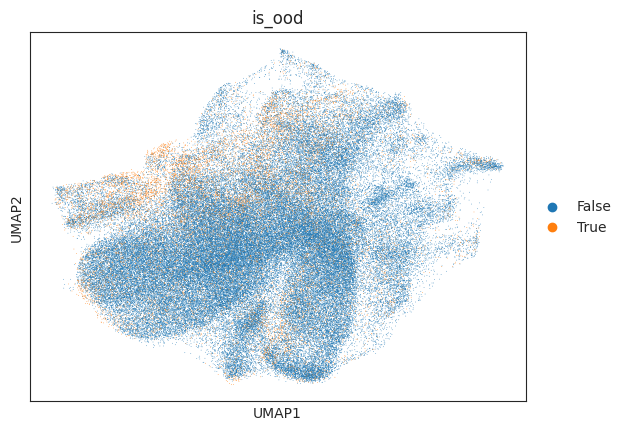

In [73]:
sc.pl.umap(adata, color="is_ood")

In [74]:
adata_train = adata[~adata.obs.is_ood == True].copy()
adata_ood = adata[adata.obs.is_ood == True].copy()

In [75]:
adata_train

AnnData object with n_obs × n_vars = 96643 × 2000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'gu

In [76]:
adata_ood

AnnData object with n_obs × n_vars = 14612 × 2000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'gu

In [77]:
adata_train.obs["perturbation_name"].value_counts()

perturbation_name
control          11835
KLF1              1954
BAK1              1451
CEBPE             1230
CEBPE+RUNX1T1     1215
                 ...  
CEBPB+FOSB          71
CBL+UBASH3A         64
C3orf72+FOXL2       59
CEBPB+JUN           59
CEBPA+JUN           54
Name: count, Length: 193, dtype: int64

Perturbations with less than 300 cells are just train.

In [78]:
rng = np.random.default_rng(0)
split_dfs = []
for drug in adata_train.obs["perturbation_name"].unique():
    adata_subset = adata_train[(adata_train.obs["perturbation_name"]==drug)]
    n_cells = adata_subset.n_obs
    if drug == "control":
        idx_test = rng.choice(np.arange(n_cells), 500, replace=False)
        remaining_idcs = set(np.arange(n_cells)) - set(idx_test)
        split = ["test" if idx in idx_test else "train" for idx in range(n_cells)]
        df = adata_subset.obs[["perturbation_name"]].copy()
        df["split"] = split
        split_dfs.append(df)
    elif n_cells>300:
        idx_test = rng.choice(np.arange(n_cells), 100, replace=False)
        split = ["test" if idx in idx_test else "train" for idx in range(n_cells)]
        df = adata_subset.obs[["perturbation_name"]].copy()
        df["split"] = split
        split_dfs.append(df)
    else:
        df = adata_subset.obs[["perturbation_name"]].copy()
        df["split"] = "train"
        split_dfs.append(df)

In [79]:
df_concat = pd.concat(split_dfs, axis=0)

In [80]:
len(df_concat), adata_train.n_obs

(96643, 96643)

In [81]:
df_concat["perturbation_name"].value_counts()

perturbation_name
control          11835
KLF1              1954
BAK1              1451
CEBPE             1230
CEBPE+RUNX1T1     1215
                 ...  
CEBPB+FOSB          71
CBL+UBASH3A         64
CEBPB+JUN           59
C3orf72+FOXL2       59
CEBPA+JUN           54
Name: count, Length: 193, dtype: int64

In [82]:
adata_train.obs["split"] = df_concat[["split"]]

In [83]:
adata_ood[adata_ood.obs["perturbation_name"]=="control"]

View of AnnData object with n_obs × n_vars = 0 × 2000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C',

In [84]:
import anndata
adata_train_final = adata_train[adata_train.obs["split"]=="train"]
adata_test_final = adata_train[adata_train.obs["split"]=="test"]
adata_ood_final = anndata.concat((adata_ood, adata_test_final[adata_test_final.obs["perturbation_name"]=="control"]))

In [85]:
adata_train_final.obs["perturbation_name"].value_counts()

perturbation_name
control          11335
KLF1              1854
BAK1              1351
CEBPE             1130
CEBPE+RUNX1T1     1115
                 ...  
CEBPB+FOSB          71
CBL+UBASH3A         64
C3orf72+FOXL2       59
CEBPB+JUN           59
CEBPA+JUN           54
Name: count, Length: 193, dtype: int64

In [86]:
adata_ood_final.obs["perturbation_name"].value_counts()

perturbation_name
TBX2+TBX3         1164
KLF1+SET           666
ELMSAN1+MAP2K3     581
MAP2K3+MAP2K6      570
control            500
MAPK1+PRTG         499
MAPK1+TGFBR2       496
ELMSAN1+MAP2K6     448
FOSB+UBASH3B       425
CEBPE+PTPN12       414
CBL+UBASH3B        406
CNN1+UBASH3B       401
BAK1+KLF1          392
DUSP9+KLF1         366
FOXA1+KLF1         361
S1PR2+SGK1         356
SGK1+TBX2          349
CBL+CNN1           348
KLF1+TGFBR2        337
CBL+PTPN12         333
BAK1+TMSB4X        328
PTPN9+UBASH3B      325
PTPN12+UBASH3A     311
MAP2K6+SPI1        302
IGDCC3+TGFBR2      301
IKZF3+MAP2K6       300
DUSP9+PRTG         297
FEV+ISL2           284
FEV+MAP7D1         277
AHR+FEV            276
PRTG+TGFBR2        264
KLF1+MAP2K6        263
UBASH3B+ZBTB25     255
FOSB+IKZF3         247
FOXA1+FOXA3        216
SAMD1+ZBTB1        190
CBL+TGFBR2         187
CEBPE+SPI1         179
FOXA3+FOXF1        175
CBFA2T3+FEV        159
IGDCC3+ZBTB25      141
IGDCC3+PRTG        140
CEBPB+CEBPE     

In [87]:
adata_test_final.obs["perturbation_name"].value_counts()

perturbation_name
control         500
PTPN1           100
PRTG            100
POU3F2          100
OSR2+UBASH3B    100
               ... 
COL2A1          100
COL1A1          100
CNNM4           100
CNN1+MAPK1      100
ETS2+MAP7D1     100
Name: count, Length: 126, dtype: int64

In [88]:
adata_train_final.varm["X_train_mean"] = adata_train_final.X.mean(axis=0).T

/tmp/ipykernel_244613/2775379558.py:1: ImplicitModificationWarning: Setting element `.varm['X_train_mean']` of view, initializing view as actual.
  adata_train_final.varm["X_train_mean"] = adata_train_final.X.mean(axis=0).T


In [89]:
from scipy.sparse import csr_matrix, vstack
train_mean = adata_train_final.varm["X_train_mean"].T
adata_train_final.layers["centered_X"] = csr_matrix(adata_train_final.X.A - train_mean)

In [90]:
adata_train_final

AnnData object with n_obs × n_vars = 83643 × 2000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'gu

In [91]:
sc.pp.pca(adata_train_final, layer = "centered_X", zero_center=False, n_comps=50)

In [92]:
adata_train_final.obsm["X_pca"].shape

(83643, 50)

In [93]:
adata_train_final

AnnData object with n_obs × n_vars = 83643 × 2000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'gu

In [94]:
adata_ood_final.varm["X_train_mean"] = adata_train_final.varm["X_train_mean"]
adata_test_final.varm["X_train_mean"] = adata_train_final.varm["X_train_mean"]

/tmp/ipykernel_244613/3355210628.py:2: ImplicitModificationWarning: Setting element `.varm['X_train_mean']` of view, initializing view as actual.
  adata_test_final.varm["X_train_mean"] = adata_train_final.varm["X_train_mean"]


In [95]:
adata_test_final.layers["centered_X"] = csr_matrix(adata_test_final.X.A - train_mean)
adata_ood_final.layers["centered_X"] = csr_matrix(adata_ood_final.X.A - train_mean)

In [96]:
adata_test_final.obsm["X_pca"] = np.matmul(adata_test_final.layers["centered_X"].A, adata_train_final.varm["PCs"])
adata_ood_final.obsm["X_pca"] = np.matmul(adata_ood_final.layers["centered_X"].A, adata_train_final.varm["PCs"])


In [97]:
adata_train_final.varm["X_train_mean"] = np.asarray(adata_train_final.varm["X_train_mean"])
adata_test_final.varm["X_train_mean"] = np.asarray(adata_test_final.varm["X_train_mean"])
adata_ood_final.varm["X_train_mean"] = np.asarray(adata_ood_final.varm["X_train_mean"])

In [4]:
output_dir = "/lustre/groups/ml01/workspace/ot_perturbation/data/norman"

In [99]:
adata_train_final

AnnData object with n_obs × n_vars = 83643 × 2000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'gu

In [100]:
adata_ood_final

AnnData object with n_obs × n_vars = 15112 × 2000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'gu

In [101]:
adata_test_final

AnnData object with n_obs × n_vars = 13000 × 2000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'gu

In [102]:
adata_train_final.obs = adata_train_final.obs.rename(columns={"perturbation_name": "condition"})
adata_ood_final.obs = adata_ood_final.obs.rename(columns={"perturbation_name": "condition"})
adata_test_final.obs = adata_test_final.obs.rename(columns={"perturbation_name": "condition"})

In [103]:
import os
adata_train_final.write(os.path.join(output_dir, "adata_train_2_seen_genes.h5ad"))
adata_ood_final.write(os.path.join(output_dir, "adata_ood_2_seen_genes.h5ad"))
adata_test_final.write(os.path.join(output_dir, "adata_test_2_seen_genes.h5ad"))

##### Add DEG

In [45]:
train = sc.read_h5ad(os.path.join(output_dir, "adata_train_2_seen_genes.h5ad"))
test = sc.read_h5ad(os.path.join(output_dir, "adata_test_2_seen_genes.h5ad"))
ood = sc.read_h5ad(os.path.join(output_dir, "adata_ood_2_seen_genes.h5ad"))

In [ ]:
get_DE_genes(train)

In [ ]:
get_DE_genes(ood)

In [ ]:
get_DE_genes(test)

In [50]:
assert "rank_genes_groups_cov_all" in train.uns.keys()
assert "rank_genes_groups_cov_all" in ood.uns.keys()
assert "rank_genes_groups_cov_all" in test.uns.keys()

In [54]:
train.write(os.path.join(output_dir, "adata_train_2_seen_genes.h5ad"))
ood.write(os.path.join(output_dir, "adata_ood_2_seen_genes.h5ad"))
test.write(os.path.join(output_dir, "adata_test_2_seen_genes.h5ad"))

Check whether the reconstruction is meanigful.

In [31]:
from sklearn.metrics import r2_score
def compute_r_squared(x: np.ndarray, y: np.ndarray) -> float:
    return r2_score(np.mean(x, axis=0), np.mean(y, axis=0))

In [ ]:
decoded_test = np.matmul(adata_test_final.obsm["X_pca"], adata_train_final.varm["PCs"].T)

In [ ]:
compute_r_squared(np.asarray(decoded_test+adata_test_final.varm["X_train_mean"].T), adata_test_final.X.A)

In [ ]:
decoded_ood = np.matmul(adata_ood_final.obsm["X_pca"], adata_train_final.varm["PCs"].T)

In [ ]:
compute_r_squared(np.asarray(decoded_ood+adata_ood_final.varm["X_train_mean"].T), adata_ood_final.X.A)

### Second split: OOD will be only combinations of 1 seen gene and 1 unseen gene.

In [109]:
gene1 = adata.obs.gene_1.unique()
gene2 = adata.obs.gene_2.unique()

In [110]:
singleton = adata[adata.obs.gene_2 == 'control'].obs.gene_1.unique()

In [111]:
combinations = np.concatenate((adata[adata.obs.gene_2 != 'control'].obs.gene_1.unique(), adata[adata.obs.gene_2 != 'control'].obs.gene_2.unique()))

In [112]:
singleton

['control', 'TSC22D1', 'MAML2', 'CEBPE', 'DUSP9', ..., 'PRDM1', 'HK2', 'EGR1', 'KIF18B', 'CDKN1C']
Length: 106
Categories (106, object): ['AHR', 'ARID1A', 'ARRDC3', 'ATL1', ..., 'ZBTB25', 'ZC3HAV1', 'ZNF318', 'control']

In [113]:
combinations

array(['KLF1', 'CEBPE', 'ETS2', 'CBL', 'ELMSAN1', 'SGK1', 'MAP2K6',
       'PTPN12', 'FOXA1', 'OSR2', 'IKZF3', 'MAP2K3', 'TBX2', 'DUSP9',
       'UBASH3B', 'FOXL2', 'PTPN9', 'IGDCC3', 'IER5L', 'CEBPA', 'BAK1',
       'UBASH3A', 'MAPK1', 'COL2A1', 'BPGM', 'KIF18B', 'BCL2L11', 'AHR',
       'FEV', 'CNN1', 'FOXA3', 'CEBPB', 'SAMD1', 'IRF1', 'HOXC13',
       'FOXF1', 'SNAI1', 'FOSB', 'S1PR2', 'PRTG', 'CLDN6', 'CBFA2T3',
       'DLX2', 'CDKN1B', 'CDKN1A', 'RHOXF2', 'C19orf26', 'PLK4',
       'C3orf72', 'MAP2K6', 'RUNX1T1', 'MAP7D1', 'PTPN9', 'LHX1',
       'TGFBR2', 'TBX3', 'SPI1', 'UBASH3B', 'FOXA3', 'IGDCC3', 'PTPN12',
       'SLC38A2', 'KLF1', 'MAPK1', 'ZBTB25', 'ETS2', 'ZNF318', 'SET',
       'LYL1', 'JUN', 'TMSB4X', 'ZC3HAV1', 'PRTG', 'MAP2K3', 'SAMD1',
       'POU3F2', 'KIF2C', 'UBASH3A', 'MEIS1', 'HOXB9', 'IKZF3', 'FOSB',
       'SNAI1', 'BCL2L11', 'ZBTB1', 'CEBPE', 'FOXL2', 'CNN1', 'ZBTB10',
       'TBX2', 'OSR2', 'SGK1', 'ISL2', 'CDKN1C', 'FEV', 'CDKN1B', 'CEBPB',
       'PRDM1', '

In [114]:
set(combinations).difference(set(singleton))

set()

There are no genes in combinations that do not appear as singletons.

In [115]:
df_effects_sorted

,conditions,sinkhorn_div
24,BAK1,24.722224
115,BCL2L11,26.296935
3,MAML2,26.538140
182,TGFBR2,26.719771
59,RUNX1T1,26.752575
...,...,...
151,CEBPA+CEBPE,157.644543
227,CEBPA+ZC3HAV1,159.242504
207,CEBPA+CEBPB,173.225772
80,CEBPA,176.338528


In [116]:
combinations_df = df_effects_sorted[df_effects_sorted['conditions'].str.contains('\+', regex=True)]


In [117]:
combinations_df

,conditions,sinkhorn_div
75,MAP2K3+MAP2K6,28.911843
137,BAK1+BCL2L11,29.296658
102,BCL2L11+TGFBR2,29.386816
71,BAK1+TMSB4X,30.026727
26,MAP2K3+SLC38A2,30.220008
...,...,...
192,CEBPE+SPI1,153.294070
151,CEBPA+CEBPE,157.644543
227,CEBPA+ZC3HAV1,159.242504
207,CEBPA+CEBPB,173.225772


In [118]:
import math

In [119]:
k_ood_drugs = math.ceil(combinations_df.shape[0]*0.2)

In [120]:
indices = np.arange(len(combinations_df))

In [121]:
len(combinations_df)/k_ood_drugs

4.851851851851852

In [122]:
drugs_ood = combinations_df.iloc[indices[::3]]

In [123]:
drugs_ood

,conditions,sinkhorn_div
75,MAP2K3+MAP2K6,28.911843
71,BAK1+TMSB4X,30.026727
139,ELMSAN1+MAP2K6,32.230826
172,FOSB+UBASH3B,34.190207
147,ELMSAN1+MAP2K3,35.591327
11,MAP2K6+SPI1,37.301629
149,BAK1+KLF1,38.611705
76,MAPK1+PRTG,39.213311
194,CEBPE+PTPN12,40.512793
122,MAPK1+TGFBR2,41.742417


In [124]:
drugs_ood[['gene_1', 'gene_2']] = drugs_ood['conditions'].str.split('+', expand=True)

/tmp/ipykernel_244613/4054427510.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drugs_ood[['gene_1', 'gene_2']] = drugs_ood['conditions'].str.split('+', expand=True)
/tmp/ipykernel_244613/4054427510.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drugs_ood[['gene_1', 'gene_2']] = drugs_ood['conditions'].str.split('+', expand=True)


Find the candidate genes.

In [125]:
single_genes = set(drugs_ood.gene_1.values).union(drugs_ood.gene_2.values)

In [126]:
single_genes

{'AHR',
 'BAK1',
 'CBFA2T3',
 'CBL',
 'CEBPA',
 'CEBPB',
 'CEBPE',
 'CNN1',
 'DUSP9',
 'ELMSAN1',
 'FEV',
 'FOSB',
 'FOXA1',
 'FOXA3',
 'FOXF1',
 'IGDCC3',
 'IKZF3',
 'ISL2',
 'KLF1',
 'MAP2K3',
 'MAP2K6',
 'MAP7D1',
 'MAPK1',
 'PRDM1',
 'PRTG',
 'PTPN12',
 'PTPN9',
 'S1PR2',
 'SAMD1',
 'SET',
 'SGK1',
 'SPI1',
 'TBX2',
 'TBX3',
 'TGFBR2',
 'TMSB4X',
 'UBASH3A',
 'UBASH3B',
 'ZBTB1',
 'ZBTB25'}

In [127]:
import random

Remove all of them would put away too many perturbations, let's leave out just a subset.

In [128]:
random.seed(42)
genes_to_remove = random.sample(list(single_genes), int(len(single_genes)/3))

In [129]:
genes_to_remove

['UBASH3A',
 'MAP2K3',
 'IGDCC3',
 'CEBPA',
 'CEBPE',
 'PRTG',
 'KLF1',
 'IKZF3',
 'FOXA1',
 'PTPN9',
 'ZBTB1',
 'FOXA3',
 'AHR']

In [130]:
adata.obs.perturbation_name.unique()

['control', 'TSC22D1', 'KLF1+MAP2K6', 'CEBPE+RUNX1T1', 'MAML2', ..., 'CDKN1A+CDKN1C', 'PLK4+STIL', 'ELMSAN1+ZBTB10', 'CDKN1C', 'C3orf72+FOXL2']
Length: 237
Categories (237, object): ['AHR', 'AHR+FEV', 'AHR+KLF1', 'ARID1A', ..., 'ZBTB25', 'ZC3HAV1', 'ZNF318', 'control']

The perturbations removed are those that have this gene as member of a combination + the singletons.

In [131]:
perturbations_removed = adata[(adata.obs.gene_1.isin(genes_to_remove)) | (adata.obs.gene_2.isin(genes_to_remove))].obs.perturbation_name.unique()

In [132]:
perturbations_removed

['KLF1+MAP2K6', 'CEBPE+RUNX1T1', 'CEBPE', 'CBL+PTPN9', 'FOXA1', ..., 'FOXA3+FOXF1', 'FOXA3+FOXL2', 'CEBPA+ZC3HAV1', 'FOXA1+FOXF1', 'IGDCC3+PRTG']
Length: 72
Categories (72, object): ['AHR', 'AHR+FEV', 'AHR+KLF1', 'BAK1+KLF1', ..., 'SAMD1+ZBTB1', 'UBASH3A', 'UBASH3A+UBASH3B', 'ZBTB1']

In [133]:
combinations_removed = drugs_ood[(drugs_ood.gene_1.isin(genes_to_remove)) | (drugs_ood.gene_2.isin(genes_to_remove))]

In [134]:
combinations_removed.shape[0]

26

We need to remove the combinations that, due to the genes selected, don't have any seen gene.

In [135]:
combinations_removed[(combinations_removed.gene_1.isin(genes_to_remove)) & (combinations_removed.gene_2.isin(genes_to_remove))]

,conditions,sinkhorn_div,gene_1,gene_2
33,FOXA1+KLF1,53.608809,FOXA1,KLF1
230,IGDCC3+PRTG,55.242374,IGDCC3,PRTG
16,FOXA1+FOXA3,61.684440,FOXA1,FOXA3


In [136]:
combinations_to_drop = combinations_removed[(combinations_removed.gene_1.isin(genes_to_remove)) & (combinations_removed.gene_2.isin(genes_to_remove))].conditions.values

In [137]:
combinations_removed.drop(combinations_removed[(combinations_removed.gene_1.isin(genes_to_remove)) & (combinations_removed.gene_2.isin(genes_to_remove))].index, inplace=True)


/tmp/ipykernel_244613/3967948776.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combinations_removed.drop(combinations_removed[(combinations_removed.gene_1.isin(genes_to_remove)) & (combinations_removed.gene_2.isin(genes_to_remove))].index, inplace=True)


In [138]:
combinations_removed.shape[0]

23

That is the total number of combinations in OOD.

In [139]:
combinations_removed[(combinations_removed.gene_1.isin(genes_to_remove)) & (combinations_removed.gene_2.isin(genes_to_remove))]

,conditions,sinkhorn_div,gene_1,gene_2


Now we need to remove the singletons (genes_to_remove) and the combinations to drop (combinations_to_drop).

In [140]:
perts_to_total_remove = genes_to_remove + list(combinations_to_drop)

In [141]:
perts_to_total_remove

['UBASH3A',
 'MAP2K3',
 'IGDCC3',
 'CEBPA',
 'CEBPE',
 'PRTG',
 'KLF1',
 'IKZF3',
 'FOXA1',
 'PTPN9',
 'ZBTB1',
 'FOXA3',
 'AHR',
 'FOXA1+KLF1',
 'IGDCC3+PRTG',
 'FOXA1+FOXA3']

This perturbations do not appear not in even in train.

In [142]:
ood_conditions = combinations_removed.conditions.values


In [143]:
ood_conditions

array(['MAP2K3+MAP2K6', 'ELMSAN1+MAP2K3', 'BAK1+KLF1', 'MAPK1+PRTG',
       'CEBPE+PTPN12', 'KLF1+MAP2K6', 'KLF1+TGFBR2', 'IGDCC3+TGFBR2',
       'KLF1+SET', 'PRTG+TGFBR2', 'PTPN9+UBASH3B', 'FOXA3+FOXF1',
       'PTPN12+UBASH3A', 'FOSB+IKZF3', 'SAMD1+ZBTB1', 'IGDCC3+ZBTB25',
       'DUSP9+KLF1', 'IKZF3+MAP2K6', 'DUSP9+PRTG', 'AHR+FEV',
       'CEBPB+CEBPE', 'CEBPE+SPI1', 'CEBPA+CEBPB'], dtype=object)

In [144]:
adata.obs["ood"] = adata.obs.apply(lambda x: x["perturbation_name"] if x["perturbation_name"] in ood_conditions else "not ood", axis=1)
adata.obs["is_ood"] = adata.obs.apply(lambda x: x["perturbation_name"] in ood_conditions, axis=1)
adata.obs["ood"] = adata.obs["ood"].astype("category")

In [145]:
adata.obs.ood

index
AAACCTGAGAAGAAGC-1        not ood
AAACCTGAGGCATGTG-1        not ood
AAACCTGAGGCCCTTG-1    KLF1+MAP2K6
AAACCTGCACGAAGCA-1        not ood
AAACCTGCAGACGTAG-1        not ood
                         ...     
TTTGTCATCAGTACGT-8        not ood
TTTGTCATCCACTCCA-8        not ood
TTTGTCATCCCAACGG-8        not ood
TTTGTCATCCTCCTAG-8        not ood
TTTGTCATCTGGCGAC-8        not ood
Name: ood, Length: 111255, dtype: category
Categories (24, object): ['AHR+FEV', 'BAK1+KLF1', 'CEBPA+CEBPB', 'CEBPB+CEBPE', ..., 'PTPN12+UBASH3A', 'PTPN9+UBASH3B', 'SAMD1+ZBTB1', 'not ood']

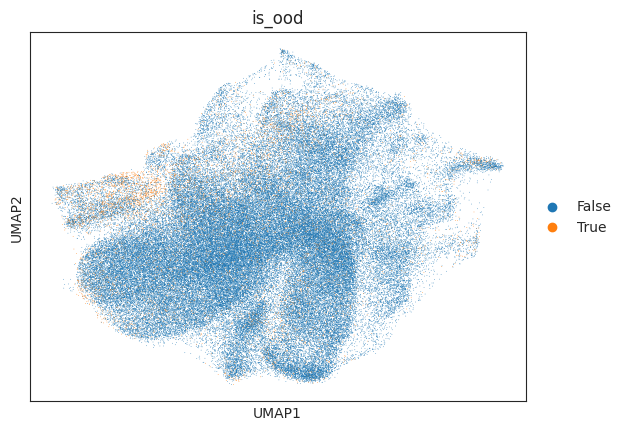

In [146]:
sc.pl.umap(adata, color="is_ood")

In [147]:
adata_train = adata[~adata.obs.is_ood == True].copy()
adata_ood = adata[adata.obs.is_ood == True].copy()

In [148]:
adata_train

AnnData object with n_obs × n_vars = 103983 × 2000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'g

In [149]:
adata_ood

AnnData object with n_obs × n_vars = 7272 × 2000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'gui

Remove the perturbations that we don't see from train. 

In [150]:
adata_train = adata_train[~adata_train.obs.perturbation_name.isin(perts_to_total_remove)]

In [151]:
adata_train.obs["perturbation_name"].value_counts()

perturbation_name
control          11835
BAK1              1451
CEBPE+RUNX1T1     1215
UBASH3B           1201
ETS2              1201
                 ...  
CEBPB+FOSB          71
CBL+UBASH3A         64
CEBPB+JUN           59
C3orf72+FOXL2       59
CEBPA+JUN           54
Name: count, Length: 198, dtype: int64

Perturbations with less than 300 cells are just train.

In [152]:
'TBX3' in adata_train.obs.perturbation_name

False

In [153]:
for i, row in combinations_removed.iterrows():
    if row['gene_1'] in adata_train.obs.perturbation_name.unique(): 
        print(i, row['gene_1'], row['gene_2'], "gene 1 is")
    elif row['gene_2'] in adata_train.obs.perturbation_name.unique(): 
        print(i, row['gene_1'], row['gene_2'], "gene 2 is")
    else:
        print("None is it")
        
    

75 MAP2K3 MAP2K6 gene 2 is
147 ELMSAN1 MAP2K3 gene 1 is
149 BAK1 KLF1 gene 1 is
76 MAPK1 PRTG gene 1 is
194 CEBPE PTPN12 gene 2 is
1 KLF1 MAP2K6 gene 2 is
198 KLF1 TGFBR2 gene 2 is
141 IGDCC3 TGFBR2 gene 2 is
134 KLF1 SET gene 2 is
184 PRTG TGFBR2 gene 2 is
53 PTPN9 UBASH3B gene 2 is
224 FOXA3 FOXF1 gene 2 is
105 PTPN12 UBASH3A gene 1 is
212 FOSB IKZF3 gene 1 is
142 SAMD1 ZBTB1 gene 1 is
54 IGDCC3 ZBTB25 gene 2 is
180 DUSP9 KLF1 gene 1 is
23 IKZF3 MAP2K6 gene 2 is
90 DUSP9 PRTG gene 1 is
197 AHR FEV gene 2 is
204 CEBPB CEBPE gene 1 is
192 CEBPE SPI1 gene 2 is
207 CEBPA CEBPB gene 2 is


In [154]:
rng = np.random.default_rng(0)
split_dfs = []
for drug in adata_train.obs["perturbation_name"].unique():
    adata_subset = adata_train[(adata_train.obs["perturbation_name"]==drug)]
    n_cells = adata_subset.n_obs
    if drug == "control":
        idx_test = rng.choice(np.arange(n_cells), 500, replace=False)
        remaining_idcs = set(np.arange(n_cells)) - set(idx_test)
        split = ["test" if idx in idx_test else "train" for idx in range(n_cells)]
        df = adata_subset.obs[["perturbation_name"]].copy()
        df["split"] = split
        split_dfs.append(df)
    elif n_cells>300:
        idx_test = rng.choice(np.arange(n_cells), 100, replace=False)
        split = ["test" if idx in idx_test else "train" for idx in range(n_cells)]
        df = adata_subset.obs[["perturbation_name"]].copy()
        df["split"] = split
        split_dfs.append(df)
    else:
        df = adata_subset.obs[["perturbation_name"]].copy()
        df["split"] = "train"
        split_dfs.append(df)

In [155]:
df_concat = pd.concat(split_dfs, axis=0)

In [156]:
len(df_concat), adata_train.n_obs

(93216, 93216)

In [157]:
df_concat["perturbation_name"].value_counts()

perturbation_name
control          11835
BAK1              1451
CEBPE+RUNX1T1     1215
UBASH3B           1201
ETS2              1201
                 ...  
CEBPB+FOSB          71
CBL+UBASH3A         64
CEBPB+JUN           59
C3orf72+FOXL2       59
CEBPA+JUN           54
Name: count, Length: 198, dtype: int64

In [158]:
adata_train.obs["split"] = df_concat[["split"]]

/tmp/ipykernel_244613/312432471.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_train.obs["split"] = df_concat[["split"]]


In [159]:
adata_ood[adata_ood.obs["perturbation_name"]=="control"]

View of AnnData object with n_obs × n_vars = 0 × 2000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C',

In [160]:
adata_train_final = adata_train[adata_train.obs["split"]=="train"]
adata_test_final = adata_train[adata_train.obs["split"]=="test"]
adata_ood_final = anndata.concat((adata_ood, adata_test_final[adata_test_final.obs["perturbation_name"]=="control"]))

In [161]:
adata_train_final.obs["perturbation_name"].value_counts()

perturbation_name
control          11335
BAK1              1351
CEBPE+RUNX1T1     1115
ETS2              1101
UBASH3B           1101
                 ...  
CEBPB+FOSB          71
CBL+UBASH3A         64
CEBPB+JUN           59
C3orf72+FOXL2       59
CEBPA+JUN           54
Name: count, Length: 198, dtype: int64

In [162]:
adata_ood_final.obs["perturbation_name"].value_counts()

perturbation_name
KLF1+SET          666
ELMSAN1+MAP2K3    581
MAP2K3+MAP2K6     570
control           500
MAPK1+PRTG        499
CEBPE+PTPN12      414
BAK1+KLF1         392
DUSP9+KLF1        366
KLF1+TGFBR2       337
PTPN9+UBASH3B     325
PTPN12+UBASH3A    311
IGDCC3+TGFBR2     301
IKZF3+MAP2K6      300
DUSP9+PRTG        297
AHR+FEV           276
PRTG+TGFBR2       264
KLF1+MAP2K6       263
FOSB+IKZF3        247
SAMD1+ZBTB1       190
CEBPE+SPI1        179
FOXA3+FOXF1       175
IGDCC3+ZBTB25     141
CEBPB+CEBPE       114
CEBPA+CEBPB        64
Name: count, dtype: int64

In [163]:
adata_test_final.obs["perturbation_name"].value_counts()

perturbation_name
control         500
PTPN1           100
POU3F2          100
OSR2+UBASH3B    100
OSR2+PTPN12     100
               ... 
CNNM4           100
CNN1+UBASH3B    100
CNN1+MAPK1      100
CNN1+ETS2       100
ETS2            100
Name: count, Length: 125, dtype: int64

In [164]:
adata_train_final.varm["X_train_mean"] = adata_train_final.X.mean(axis=0).T

/tmp/ipykernel_244613/2775379558.py:1: ImplicitModificationWarning: Setting element `.varm['X_train_mean']` of view, initializing view as actual.
  adata_train_final.varm["X_train_mean"] = adata_train_final.X.mean(axis=0).T


In [165]:
from scipy.sparse import csr_matrix, vstack
train_mean = adata_train_final.varm["X_train_mean"].T
adata_train_final.layers["centered_X"] = csr_matrix(adata_train_final.X.A - train_mean)

In [166]:
adata_train_final

AnnData object with n_obs × n_vars = 80316 × 2000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'gu

In [167]:
sc.pp.pca(adata_train_final, layer = "centered_X", zero_center=False, n_comps=50)

In [168]:
adata_train_final.obsm["X_pca"].shape

(80316, 50)

In [169]:
adata_train_final

AnnData object with n_obs × n_vars = 80316 × 2000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'gu

In [170]:
adata_ood_final.varm["X_train_mean"] = adata_train_final.varm["X_train_mean"]
adata_test_final.varm["X_train_mean"] = adata_train_final.varm["X_train_mean"]

/tmp/ipykernel_244613/3355210628.py:2: ImplicitModificationWarning: Setting element `.varm['X_train_mean']` of view, initializing view as actual.
  adata_test_final.varm["X_train_mean"] = adata_train_final.varm["X_train_mean"]


In [171]:
adata_test_final.layers["centered_X"] = csr_matrix(adata_test_final.X.A - train_mean)
adata_ood_final.layers["centered_X"] = csr_matrix(adata_ood_final.X.A - train_mean)

In [172]:
adata_test_final.obsm["X_pca"] = np.matmul(adata_test_final.layers["centered_X"].A, adata_train_final.varm["PCs"])
adata_ood_final.obsm["X_pca"] = np.matmul(adata_ood_final.layers["centered_X"].A, adata_train_final.varm["PCs"])


In [173]:
adata_train_final.varm["X_train_mean"] = np.asarray(adata_train_final.varm["X_train_mean"])
adata_test_final.varm["X_train_mean"] = np.asarray(adata_test_final.varm["X_train_mean"])
adata_ood_final.varm["X_train_mean"] = np.asarray(adata_ood_final.varm["X_train_mean"])

In [174]:
output_dir = "/lustre/groups/ml01/workspace/ot_perturbation/data/norman"

In [175]:
adata_train_final

AnnData object with n_obs × n_vars = 80316 × 2000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'gu

In [176]:
adata_ood_final

AnnData object with n_obs × n_vars = 7772 × 2000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'gui

In [177]:
adata_test_final

AnnData object with n_obs × n_vars = 12900 × 2000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'gu

In [178]:
adata_train_final.obs = adata_train_final.obs.rename(columns={"perturbation_name": "condition"})
adata_ood_final.obs = adata_ood_final.obs.rename(columns={"perturbation_name": "condition"})
adata_test_final.obs = adata_test_final.obs.rename(columns={"perturbation_name": "condition"})

In [179]:
adata_train_final.write(os.path.join(output_dir, "adata_train_1_seen_genes.h5ad"))
adata_ood_final.write(os.path.join(output_dir, "adata_ood_1_seen_genes.h5ad"))
adata_test_final.write(os.path.join(output_dir, "adata_test_1_seen_genes.h5ad"))

##### Add DEG

In [55]:
train = sc.read_h5ad(os.path.join(output_dir, "adata_train_1_seen_genes.h5ad"))
test = sc.read_h5ad(os.path.join(output_dir, "adata_test_1_seen_genes.h5ad"))
ood = sc.read_h5ad(os.path.join(output_dir, "adata_ood_1_seen_genes.h5ad"))

In [ ]:
get_DE_genes(train)

In [ ]:
get_DE_genes(ood)

In [ ]:
get_DE_genes(test)

In [59]:
assert "rank_genes_groups_cov_all" in train.uns.keys()
assert "rank_genes_groups_cov_all" in ood.uns.keys()
assert "rank_genes_groups_cov_all" in test.uns.keys()

In [60]:
train.write(os.path.join(output_dir, "adata_train_1_seen_genes.h5ad"))
ood.write(os.path.join(output_dir, "adata_ood_1_seen_genes.h5ad"))
test.write(os.path.join(output_dir, "adata_test_1_seen_genes.h5ad"))

Check that reconstruction is meaningful

In [180]:
from sklearn.metrics import r2_score
def compute_r_squared(x: np.ndarray, y: np.ndarray) -> float:
    return r2_score(np.mean(x, axis=0), np.mean(y, axis=0))

In [181]:
decoded_test = np.matmul(adata_test_final.obsm["X_pca"], adata_train_final.varm["PCs"].T)

In [182]:
compute_r_squared(np.asarray(decoded_test+adata_test_final.varm["X_train_mean"].T), adata_test_final.X.A)

0.9999797512144968

In [183]:
decoded_ood = np.matmul(adata_ood_final.obsm["X_pca"], adata_train_final.varm["PCs"].T)

In [184]:
compute_r_squared(np.asarray(decoded_ood+adata_ood_final.varm["X_train_mean"].T), adata_ood_final.X.A)

0.9996260071823206

### Third split: OOD will be only combinations of 2 unseen genes.

In [185]:
gene1 = adata.obs.gene_1.unique()
gene2 = adata.obs.gene_2.unique()

In [186]:
singleton = adata[adata.obs.gene_2 == 'control'].obs.gene_1.unique()

In [187]:
combinations = np.concatenate((adata[adata.obs.gene_2 != 'control'].obs.gene_1.unique(), adata[adata.obs.gene_2 != 'control'].obs.gene_2.unique()))

In [188]:
singleton

['control', 'TSC22D1', 'MAML2', 'CEBPE', 'DUSP9', ..., 'PRDM1', 'HK2', 'EGR1', 'KIF18B', 'CDKN1C']
Length: 106
Categories (106, object): ['AHR', 'ARID1A', 'ARRDC3', 'ATL1', ..., 'ZBTB25', 'ZC3HAV1', 'ZNF318', 'control']

In [189]:
combinations

array(['KLF1', 'CEBPE', 'ETS2', 'CBL', 'ELMSAN1', 'SGK1', 'MAP2K6',
       'PTPN12', 'FOXA1', 'OSR2', 'IKZF3', 'MAP2K3', 'TBX2', 'DUSP9',
       'UBASH3B', 'FOXL2', 'PTPN9', 'IGDCC3', 'IER5L', 'CEBPA', 'BAK1',
       'UBASH3A', 'MAPK1', 'COL2A1', 'BPGM', 'KIF18B', 'BCL2L11', 'AHR',
       'FEV', 'CNN1', 'FOXA3', 'CEBPB', 'SAMD1', 'IRF1', 'HOXC13',
       'FOXF1', 'SNAI1', 'FOSB', 'S1PR2', 'PRTG', 'CLDN6', 'CBFA2T3',
       'DLX2', 'CDKN1B', 'CDKN1A', 'RHOXF2', 'C19orf26', 'PLK4',
       'C3orf72', 'MAP2K6', 'RUNX1T1', 'MAP7D1', 'PTPN9', 'LHX1',
       'TGFBR2', 'TBX3', 'SPI1', 'UBASH3B', 'FOXA3', 'IGDCC3', 'PTPN12',
       'SLC38A2', 'KLF1', 'MAPK1', 'ZBTB25', 'ETS2', 'ZNF318', 'SET',
       'LYL1', 'JUN', 'TMSB4X', 'ZC3HAV1', 'PRTG', 'MAP2K3', 'SAMD1',
       'POU3F2', 'KIF2C', 'UBASH3A', 'MEIS1', 'HOXB9', 'IKZF3', 'FOSB',
       'SNAI1', 'BCL2L11', 'ZBTB1', 'CEBPE', 'FOXL2', 'CNN1', 'ZBTB10',
       'TBX2', 'OSR2', 'SGK1', 'ISL2', 'CDKN1C', 'FEV', 'CDKN1B', 'CEBPB',
       'PRDM1', '

In [190]:
set(combinations).difference(set(singleton))

set()

There are no genes in combinations that do not appear as singletons.

In [191]:
df_effects_sorted

,conditions,sinkhorn_div
24,BAK1,24.722224
115,BCL2L11,26.296935
3,MAML2,26.538140
182,TGFBR2,26.719771
59,RUNX1T1,26.752575
...,...,...
151,CEBPA+CEBPE,157.644543
227,CEBPA+ZC3HAV1,159.242504
207,CEBPA+CEBPB,173.225772
80,CEBPA,176.338528


In [192]:
combinations_df = df_effects_sorted[df_effects_sorted['conditions'].str.contains('\+', regex=True)]


In [193]:
combinations_df

,conditions,sinkhorn_div
75,MAP2K3+MAP2K6,28.911843
137,BAK1+BCL2L11,29.296658
102,BCL2L11+TGFBR2,29.386816
71,BAK1+TMSB4X,30.026727
26,MAP2K3+SLC38A2,30.220008
...,...,...
192,CEBPE+SPI1,153.294070
151,CEBPA+CEBPE,157.644543
227,CEBPA+ZC3HAV1,159.242504
207,CEBPA+CEBPB,173.225772


In [194]:
import math

In [195]:
k_ood_drugs = math.ceil(combinations_df.shape[0]*0.2)

In [196]:
indices = np.arange(len(combinations_df))

In [197]:
len(combinations_df)/k_ood_drugs

4.851851851851852

In [198]:
drugs_ood = combinations_df.iloc[indices[::3]]

In [199]:
drugs_ood

,conditions,sinkhorn_div
75,MAP2K3+MAP2K6,28.911843
71,BAK1+TMSB4X,30.026727
139,ELMSAN1+MAP2K6,32.230826
172,FOSB+UBASH3B,34.190207
147,ELMSAN1+MAP2K3,35.591327
11,MAP2K6+SPI1,37.301629
149,BAK1+KLF1,38.611705
76,MAPK1+PRTG,39.213311
194,CEBPE+PTPN12,40.512793
122,MAPK1+TGFBR2,41.742417


In [200]:
drugs_ood.shape[0]

44

In [201]:
drugs_ood[['gene_1', 'gene_2']] = drugs_ood['conditions'].str.split('+', expand=True)

/tmp/ipykernel_244613/4054427510.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drugs_ood[['gene_1', 'gene_2']] = drugs_ood['conditions'].str.split('+', expand=True)
/tmp/ipykernel_244613/4054427510.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drugs_ood[['gene_1', 'gene_2']] = drugs_ood['conditions'].str.split('+', expand=True)


In [202]:
perturbations_to_choose = drugs_ood.conditions.values

In [203]:
random.seed(42)
perts_to_remove = random.sample(list(perturbations_to_choose), int(len(perturbations_to_choose)/3))

In [204]:
perts_to_remove 

['CBFA2T3+FEV',
 'MAPK1+PRTG',
 'BAK1+TMSB4X',
 'FOXA1+KLF1',
 'PRTG+TGFBR2',
 'CBL+TGFBR2',
 'CEBPE+PTPN12',
 'BAK1+KLF1',
 'DUSP9+PRTG',
 'MAP2K6+SPI1',
 'S1PR2+SGK1',
 'ELMSAN1+MAP2K6',
 'CEBPB+CEBPE',
 'DUSP9+KLF1']

In [205]:
genes_to_remove = set(list(drugs_ood[drugs_ood.conditions.isin(perts_to_remove)].gene_1.values)+list(drugs_ood[drugs_ood.conditions.isin(perts_to_remove)].gene_2.values))

In [206]:
genes_to_remove

{'BAK1',
 'CBFA2T3',
 'CBL',
 'CEBPB',
 'CEBPE',
 'DUSP9',
 'ELMSAN1',
 'FEV',
 'FOXA1',
 'KLF1',
 'MAP2K6',
 'MAPK1',
 'PRTG',
 'PTPN12',
 'S1PR2',
 'SGK1',
 'SPI1',
 'TGFBR2',
 'TMSB4X'}

In [207]:
adata.obs.perturbation_name.unique()

['control', 'TSC22D1', 'KLF1+MAP2K6', 'CEBPE+RUNX1T1', 'MAML2', ..., 'CDKN1A+CDKN1C', 'PLK4+STIL', 'ELMSAN1+ZBTB10', 'CDKN1C', 'C3orf72+FOXL2']
Length: 237
Categories (237, object): ['AHR', 'AHR+FEV', 'AHR+KLF1', 'ARID1A', ..., 'ZBTB25', 'ZC3HAV1', 'ZNF318', 'control']

In [208]:
perturbations_removed = adata[(adata.obs.gene_1.isin(genes_to_remove)) | (adata.obs.gene_2.isin(genes_to_remove))].obs.perturbation_name.unique()

In [209]:
perturbations_removed

['KLF1+MAP2K6', 'CEBPE+RUNX1T1', 'CEBPE', 'CBL+PTPN9', 'ELMSAN1+LHX1', ..., 'CBFA2T3+PRDM1', 'DUSP9+SNAI1', 'FOXA1+FOXF1', 'IGDCC3+PRTG', 'ELMSAN1+ZBTB10']
Length: 103
Categories (103, object): ['AHR+FEV', 'AHR+KLF1', 'BAK1', 'BAK1+BCL2L11', ..., 'SGK1+TBX3', 'SPI1', 'TGFBR2', 'TMSB4X']

In [210]:
perts_to_total_remove = perturbations_removed

In [211]:
perts_to_total_remove

['KLF1+MAP2K6', 'CEBPE+RUNX1T1', 'CEBPE', 'CBL+PTPN9', 'ELMSAN1+LHX1', ..., 'CBFA2T3+PRDM1', 'DUSP9+SNAI1', 'FOXA1+FOXF1', 'IGDCC3+PRTG', 'ELMSAN1+ZBTB10']
Length: 103
Categories (103, object): ['AHR+FEV', 'AHR+KLF1', 'BAK1', 'BAK1+BCL2L11', ..., 'SGK1+TBX3', 'SPI1', 'TGFBR2', 'TMSB4X']

This perturbations do not appear not in even in train.

In [212]:
combinations_removed = drugs_ood[drugs_ood.conditions.isin(perts_to_remove)]

In [213]:
combinations_removed

,conditions,sinkhorn_div,gene_1,gene_2
71,BAK1+TMSB4X,30.026727,BAK1,TMSB4X
139,ELMSAN1+MAP2K6,32.230826,ELMSAN1,MAP2K6
11,MAP2K6+SPI1,37.301629,MAP2K6,SPI1
149,BAK1+KLF1,38.611705,BAK1,KLF1
76,MAPK1+PRTG,39.213311,MAPK1,PRTG
194,CEBPE+PTPN12,40.512793,CEBPE,PTPN12
168,CBL+TGFBR2,48.393929,CBL,TGFBR2
184,PRTG+TGFBR2,50.389139,PRTG,TGFBR2
33,FOXA1+KLF1,53.608809,FOXA1,KLF1
179,S1PR2+SGK1,67.197686,S1PR2,SGK1


In [214]:
combinations_removed.shape[0]

14

In [215]:
ood_conditions = combinations_removed.conditions.values


In [216]:
ood_conditions

array(['BAK1+TMSB4X', 'ELMSAN1+MAP2K6', 'MAP2K6+SPI1', 'BAK1+KLF1',
       'MAPK1+PRTG', 'CEBPE+PTPN12', 'CBL+TGFBR2', 'PRTG+TGFBR2',
       'FOXA1+KLF1', 'S1PR2+SGK1', 'DUSP9+KLF1', 'DUSP9+PRTG',
       'CBFA2T3+FEV', 'CEBPB+CEBPE'], dtype=object)

In [217]:
adata.obs["ood"] = adata.obs.apply(lambda x: x["perturbation_name"] if x["perturbation_name"] in ood_conditions else "not ood", axis=1)
adata.obs["is_ood"] = adata.obs.apply(lambda x: x["perturbation_name"] in ood_conditions, axis=1)
adata.obs["ood"] = adata.obs["ood"].astype("category")

In [218]:
adata.obs.ood

index
AAACCTGAGAAGAAGC-1    not ood
AAACCTGAGGCATGTG-1    not ood
AAACCTGAGGCCCTTG-1    not ood
AAACCTGCACGAAGCA-1    not ood
AAACCTGCAGACGTAG-1    not ood
                       ...   
TTTGTCATCAGTACGT-8    not ood
TTTGTCATCCACTCCA-8    not ood
TTTGTCATCCCAACGG-8    not ood
TTTGTCATCCTCCTAG-8    not ood
TTTGTCATCTGGCGAC-8    not ood
Name: ood, Length: 111255, dtype: category
Categories (15, object): ['BAK1+KLF1', 'BAK1+TMSB4X', 'CBFA2T3+FEV', 'CBL+TGFBR2', ..., 'MAPK1+PRTG', 'PRTG+TGFBR2', 'S1PR2+SGK1', 'not ood']

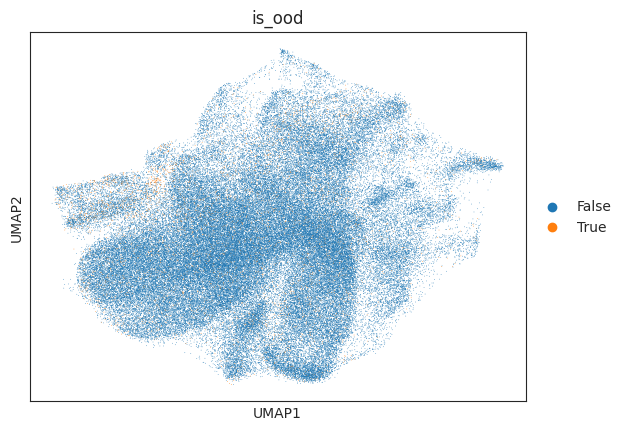

In [219]:
sc.pl.umap(adata, color="is_ood")

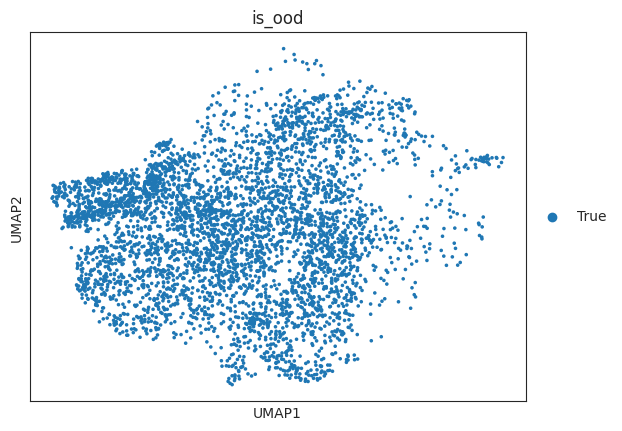

In [220]:
sc.pl.umap(adata[adata.obs.is_ood==True], color="is_ood")

In [221]:
adata_train = adata[~adata.obs.is_ood == True].copy()
adata_ood = adata[adata.obs.is_ood == True].copy()

In [222]:
adata_train

AnnData object with n_obs × n_vars = 106768 × 2000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'g

In [223]:
adata_ood

AnnData object with n_obs × n_vars = 4487 × 2000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'gui

Remove the perturbations that we don't see from train.

In [224]:
adata_train = adata_train[~adata_train.obs.perturbation_name.isin(perts_to_total_remove)]

In [225]:
adata_train.obs["perturbation_name"].value_counts()

perturbation_name
control          11835
ETS2              1201
UBASH3B           1201
TBX2+TBX3         1164
OSR2              1002
                 ...  
DLX2+ZBTB10         89
CEBPA+ZC3HAV1       86
PLK4+STIL           81
C3orf72+FOXL2       59
CEBPA+JUN           54
Name: count, Length: 134, dtype: int64

Perturbations with less than 300 cells are just train.

In [226]:
'TBX3' in adata_train.obs.perturbation_name

False

In [227]:
for i, row in combinations_removed.iterrows():
    if row['gene_1'] in adata_train.obs.perturbation_name.unique(): 
        print(i, row['gene_1'], row['gene_2'], "gene 1 is")
    elif row['gene_2'] in adata_train.obs.perturbation_name.unique(): 
        print(i, row['gene_1'], row['gene_2'], "gene 2 is")
    else:
        print(i, row['gene_1'], row['gene_2'], "none is")

71 BAK1 TMSB4X none is
139 ELMSAN1 MAP2K6 none is
11 MAP2K6 SPI1 none is
149 BAK1 KLF1 none is
76 MAPK1 PRTG none is
194 CEBPE PTPN12 none is
168 CBL TGFBR2 none is
184 PRTG TGFBR2 none is
33 FOXA1 KLF1 none is
179 S1PR2 SGK1 none is
180 DUSP9 KLF1 none is
90 DUSP9 PRTG none is
200 CBFA2T3 FEV none is
204 CEBPB CEBPE none is


In [228]:
rng = np.random.default_rng(0)
split_dfs = []
for drug in adata_train.obs["perturbation_name"].unique():
    adata_subset = adata_train[(adata_train.obs["perturbation_name"]==drug)]
    n_cells = adata_subset.n_obs
    if drug == "control":
        idx_test = rng.choice(np.arange(n_cells), 500, replace=False)
        remaining_idcs = set(np.arange(n_cells)) - set(idx_test)
        split = ["test" if idx in idx_test else "train" for idx in range(n_cells)]
        df = adata_subset.obs[["perturbation_name"]].copy()
        df["split"] = split
        split_dfs.append(df)
    elif n_cells>300:
        idx_test = rng.choice(np.arange(n_cells), 100, replace=False)
        split = ["test" if idx in idx_test else "train" for idx in range(n_cells)]
        df = adata_subset.obs[["perturbation_name"]].copy()
        df["split"] = split
        split_dfs.append(df)
    else:
        df = adata_subset.obs[["perturbation_name"]].copy()
        df["split"] = "train"
        split_dfs.append(df)

In [229]:
df_concat = pd.concat(split_dfs, axis=0)

In [230]:
len(df_concat), adata_train.n_obs

(68479, 68479)

In [231]:
df_concat["perturbation_name"].value_counts()

perturbation_name
control          11835
UBASH3B           1201
ETS2              1201
TBX2+TBX3         1164
OSR2              1002
                 ...  
DLX2+ZBTB10         89
CEBPA+ZC3HAV1       86
PLK4+STIL           81
C3orf72+FOXL2       59
CEBPA+JUN           54
Name: count, Length: 134, dtype: int64

In [232]:
adata_train.obs["split"] = df_concat[["split"]]

/tmp/ipykernel_244613/312432471.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_train.obs["split"] = df_concat[["split"]]


In [233]:
adata_ood[adata_ood.obs["perturbation_name"]=="control"]

View of AnnData object with n_obs × n_vars = 0 × 2000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C',

In [234]:
adata_train_final = adata_train[adata_train.obs["split"]=="train"]
adata_test_final = adata_train[adata_train.obs["split"]=="test"]
adata_ood_final = anndata.concat((adata_ood, adata_test_final[adata_test_final.obs["perturbation_name"]=="control"]))

In [235]:
adata_train_final.obs["perturbation_name"].value_counts()

perturbation_name
control          11335
UBASH3B           1101
ETS2              1101
TBX2+TBX3         1064
OSR2               902
                 ...  
DLX2+ZBTB10         89
CEBPA+ZC3HAV1       86
PLK4+STIL           81
C3orf72+FOXL2       59
CEBPA+JUN           54
Name: count, Length: 134, dtype: int64

In [236]:
adata_ood_final.obs["perturbation_name"].value_counts()

perturbation_name
control           500
MAPK1+PRTG        499
ELMSAN1+MAP2K6    448
CEBPE+PTPN12      414
BAK1+KLF1         392
DUSP9+KLF1        366
FOXA1+KLF1        361
S1PR2+SGK1        356
BAK1+TMSB4X       328
MAP2K6+SPI1       302
DUSP9+PRTG        297
PRTG+TGFBR2       264
CBL+TGFBR2        187
CBFA2T3+FEV       159
CEBPB+CEBPE       114
Name: count, dtype: int64

In [237]:
adata_test_final.obs["perturbation_name"].value_counts()

perturbation_name
control          500
RHOXF2           100
PTPN9+UBASH3B    100
PTPN9            100
PTPN1            100
                ... 
ETS2+MAP7D1      100
ETS2+IKZF3       100
ETS2+IGDCC3      100
ETS2             100
FOXL2            100
Name: count, Length: 85, dtype: int64

In [238]:
adata_train_final.varm["X_train_mean"] = adata_train_final.X.mean(axis=0).T

/tmp/ipykernel_244613/2775379558.py:1: ImplicitModificationWarning: Setting element `.varm['X_train_mean']` of view, initializing view as actual.
  adata_train_final.varm["X_train_mean"] = adata_train_final.X.mean(axis=0).T


In [239]:
from scipy.sparse import csr_matrix, vstack
train_mean = adata_train_final.varm["X_train_mean"].T
adata_train_final.layers["centered_X"] = csr_matrix(adata_train_final.X.A - train_mean)

In [240]:
adata_train_final

AnnData object with n_obs × n_vars = 59579 × 2000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'gu

In [241]:
sc.pp.pca(adata_train_final, layer = "centered_X", zero_center=False, n_comps=50)

In [242]:
adata_train_final.obsm["X_pca"].shape

(59579, 50)

In [243]:
adata_train_final

AnnData object with n_obs × n_vars = 59579 × 2000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'gu

In [244]:
adata_ood_final.varm["X_train_mean"] = adata_train_final.varm["X_train_mean"]
adata_test_final.varm["X_train_mean"] = adata_train_final.varm["X_train_mean"]

/tmp/ipykernel_244613/3355210628.py:2: ImplicitModificationWarning: Setting element `.varm['X_train_mean']` of view, initializing view as actual.
  adata_test_final.varm["X_train_mean"] = adata_train_final.varm["X_train_mean"]


In [245]:
adata_test_final.layers["centered_X"] = csr_matrix(adata_test_final.X.A - train_mean)
adata_ood_final.layers["centered_X"] = csr_matrix(adata_ood_final.X.A - train_mean)

In [246]:
adata_test_final.obsm["X_pca"] = np.matmul(adata_test_final.layers["centered_X"].A, adata_train_final.varm["PCs"])
adata_ood_final.obsm["X_pca"] = np.matmul(adata_ood_final.layers["centered_X"].A, adata_train_final.varm["PCs"])


In [247]:
adata_train_final.varm["X_train_mean"] = np.asarray(adata_train_final.varm["X_train_mean"])
adata_test_final.varm["X_train_mean"] = np.asarray(adata_test_final.varm["X_train_mean"])
adata_ood_final.varm["X_train_mean"] = np.asarray(adata_ood_final.varm["X_train_mean"])

In [248]:
output_dir = "/lustre/groups/ml01/workspace/ot_perturbation/data/norman"

In [249]:
adata_train_final

AnnData object with n_obs × n_vars = 59579 × 2000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'gu

In [250]:
adata_ood_final

AnnData object with n_obs × n_vars = 4987 × 2000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'gui

In [251]:
adata_test_final

AnnData object with n_obs × n_vars = 8900 × 2000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'gui

In [252]:
adata_train_final.obs = adata_train_final.obs.rename(columns={"perturbation_name": "condition"})
adata_ood_final.obs = adata_ood_final.obs.rename(columns={"perturbation_name": "condition"})
adata_test_final.obs = adata_test_final.obs.rename(columns={"perturbation_name": "condition"})

In [253]:
adata_train_final.write(os.path.join(output_dir, "adata_train_0_seen_genes.h5ad"))
adata_ood_final.write(os.path.join(output_dir, "adata_ood_0_seen_genes.h5ad"))
adata_test_final.write(os.path.join(output_dir, "adata_test_0_seen_genes.h5ad"))

##### Add DEG

In [61]:
train = sc.read_h5ad(os.path.join(output_dir, "adata_train_0_seen_genes.h5ad"))
test = sc.read_h5ad(os.path.join(output_dir, "adata_test_0_seen_genes.h5ad"))
ood = sc.read_h5ad(os.path.join(output_dir, "adata_ood_0_seen_genes.h5ad"))

In [ ]:
get_DE_genes(train)

In [ ]:
get_DE_genes(ood)

In [ ]:
get_DE_genes(test)

In [65]:
assert "rank_genes_groups_cov_all" in train.uns.keys()
assert "rank_genes_groups_cov_all" in ood.uns.keys()
assert "rank_genes_groups_cov_all" in test.uns.keys()

In [66]:
train.write(os.path.join(output_dir, "adata_train_0_seen_genes.h5ad"))
ood.write(os.path.join(output_dir, "adata_ood_0_seen_genes.h5ad"))
test.write(os.path.join(output_dir, "adata_test_0_seen_genes.h5ad"))

Check that reconstruction is meaningful

In [254]:
from sklearn.metrics import r2_score
def compute_r_squared(x: np.ndarray, y: np.ndarray) -> float:
    return r2_score(np.mean(x, axis=0), np.mean(y, axis=0))

In [255]:
decoded_test = np.matmul(adata_test_final.obsm["X_pca"], adata_train_final.varm["PCs"].T)

In [256]:
compute_r_squared(np.asarray(decoded_test+adata_test_final.varm["X_train_mean"].T), adata_test_final.X.A)

0.9999776046888955

In [257]:
decoded_ood = np.matmul(adata_ood_final.obsm["X_pca"], adata_train_final.varm["PCs"].T)